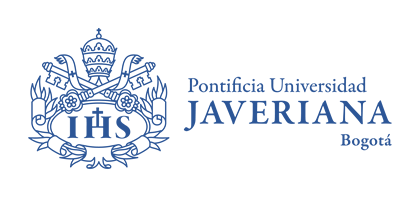

# **Proyecto Grafos - Tópicos Avanzados Analítica**

### **Realizado por:**

- Juan Ramirez
- Juan Cuellar
- Joel Marquez
- Camila Arias
- Felipe Clavijo

### **Resumen:**

El siguiente Notebook tiene como propósito mostrar la solución al problema de clasificación de productos de amazon, mediante **Grafos** con base en lo aprendido en la clase de tópicos avanzados para analítica.


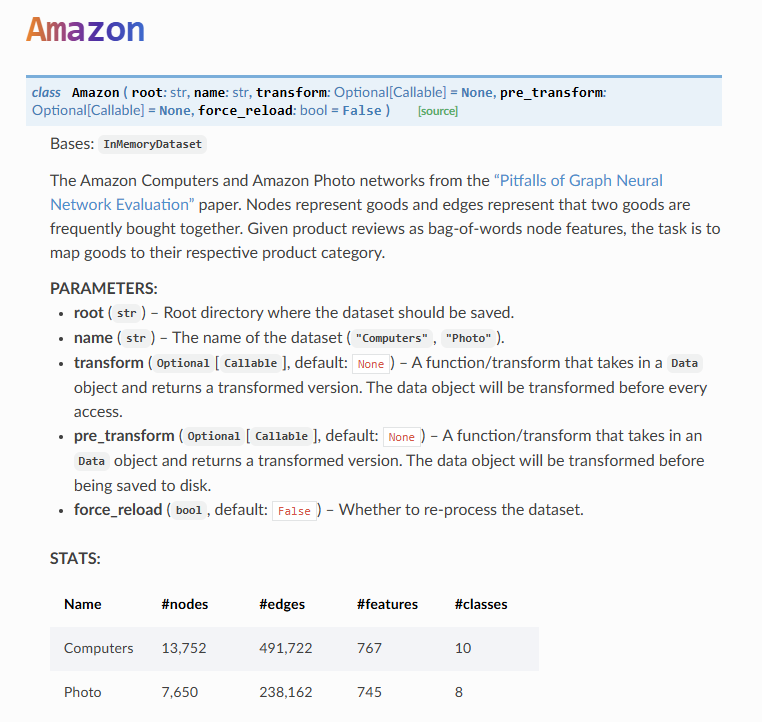

# **0. Librerías**

A continuación se presentan las librerías empleadas para la solución del ejercicio

In [2]:
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 46.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [1]:
# Correr para instalar, en caso de ser necesario
!pip install torch torchvision
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.5 MB/s eta 0:00:00


In [2]:
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint

from torch_geometric.datasets import Amazon #Dataset seleccionado

%matplotlib inline

In [3]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

# **1. Lectura de data**

En las siguientes líneas se realiza la lectura de la data.

Se lee el modelo

In [5]:
dataset = Amazon(root='str', name='Computers')

Processing...
Done!


Se revisa los nodos y conexiones del modelo.

In [6]:
[print(idx, i) for idx, i in enumerate(dataset)] #Se busca los datasets que hay dentro de la librería

0 Data(x=[13752, 767], edge_index=[2, 491722], y=[13752])


[None]

In [7]:
data = dataset[0] # Se selecciona el dataset

Se leen las conexiones entre cada nodo

In [8]:
df = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])
print(f"Se tienen: {len(df)} conexiones\n")
df.head()

Se tienen: 491722 conexiones



start_node  end_node
0           0       507
1           0      6551
2           0      8210
3           0      9745
4           1       184

In [143]:
# Información básica del dataset
print(f'Dataset: {dataset}')
print('-----------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}') #Caracteristacas de cada nodo
print(f'Number of classes: {dataset.num_classes}\t\t(Explicit Languaje),(Non Explicit Language)') #Clases a predecir - usuario usa lenguaje inapropiado o no

# Información de la grafica
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: AmazonComputers()
-----------------------
Number of graphs: 1
Number of features: 767
Number of classes: 10		(Explicit Languaje),(Non Explicit Language)

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


Se lee el grafo mediante la librería de networkx

In [10]:
G = nx.from_pandas_edgelist(df, "start_node", "end_node")

Se realiza una visualización inicial aleatoria

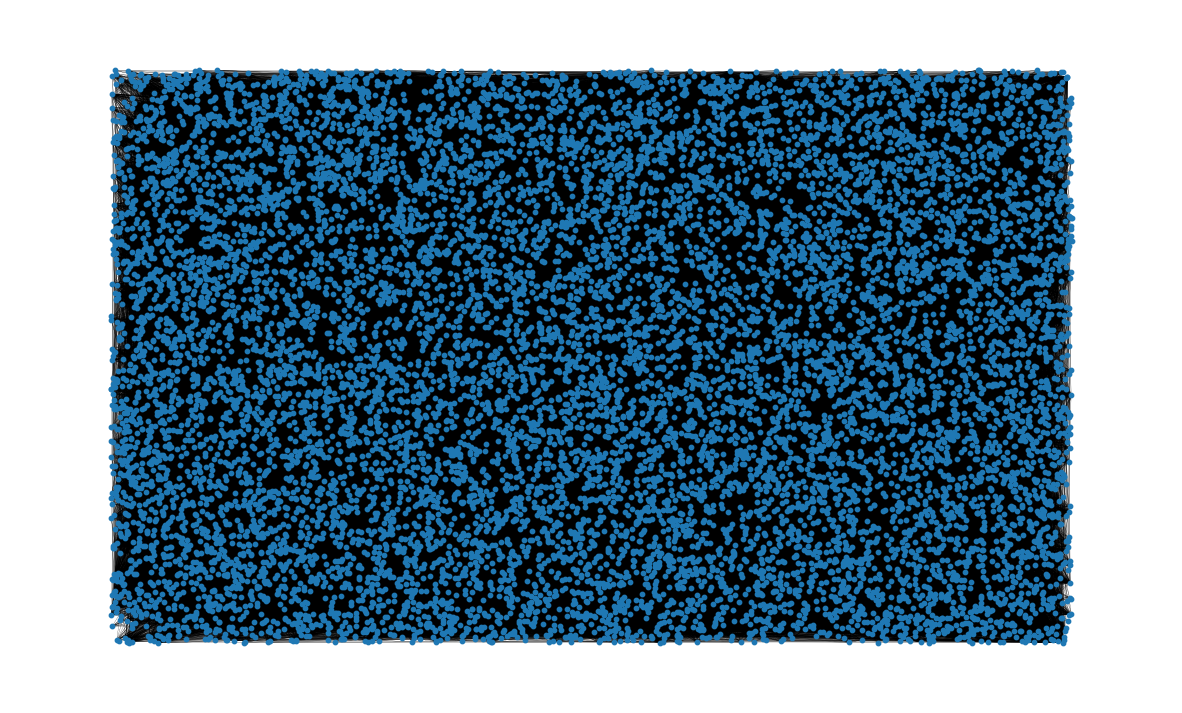

In [10]:
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=nx.random_layout(G), ax=ax, **plot_options)

Se realiza una visualización con Spring Layout

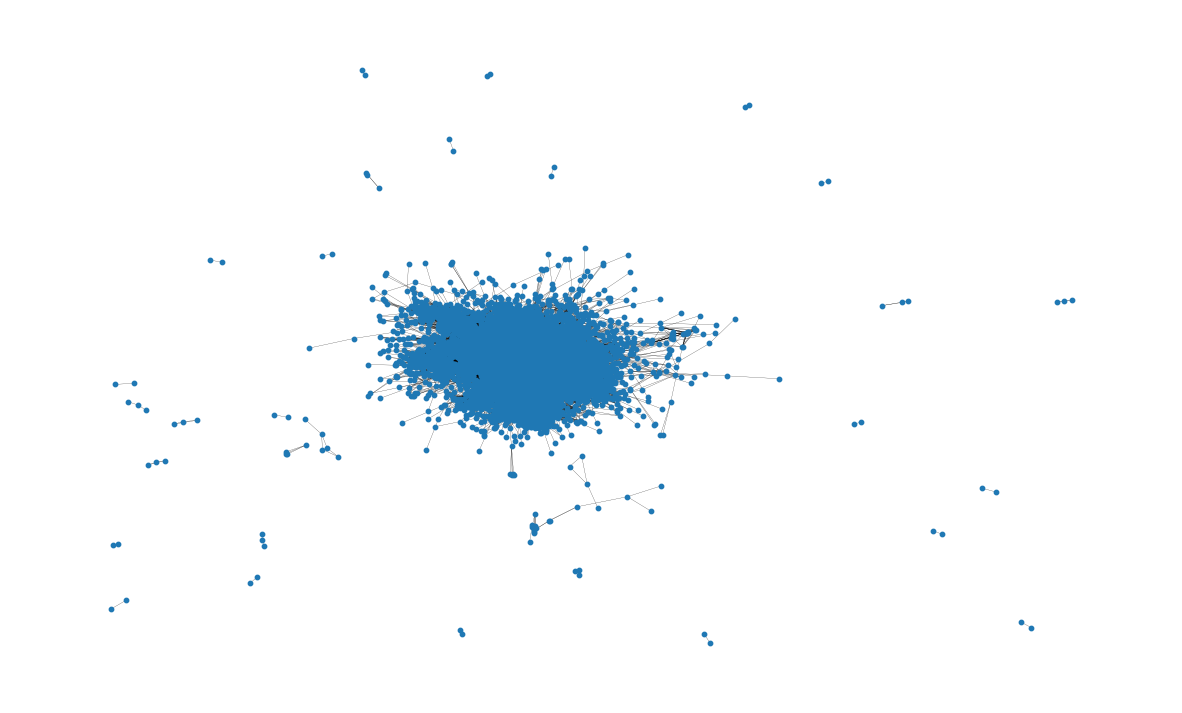

In [ ]:
pos = nx.spring_layout(G, iterations=20, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [52]:
# Encontrar el nodo con el grado más alto (nodo con más conexiones)
node = max(dict(G.degree()).items(), key=lambda x: x[1])[0]

# Crear el grafo de ego a partir del nodo con el grado más alto
ego_graph = nx.ego_graph(G, node)

# Obtener el número de nodos y aristas del grafo de ego
num_nodos_ego = ego_graph.number_of_nodes()
num_aristas_ego = ego_graph.number_of_edges()

print(f'Nodo central (con más conexiones): {node}')
print(f'Número de nodos en el grafo de ego: {num_nodos_ego}')
print(f'Número de aristas en el grafo de ego: {num_aristas_ego}')

Nodo central (con más conexiones): 12888
Número de nodos en el grafo de ego: 2993
Número de aristas en el grafo de ego: 86338


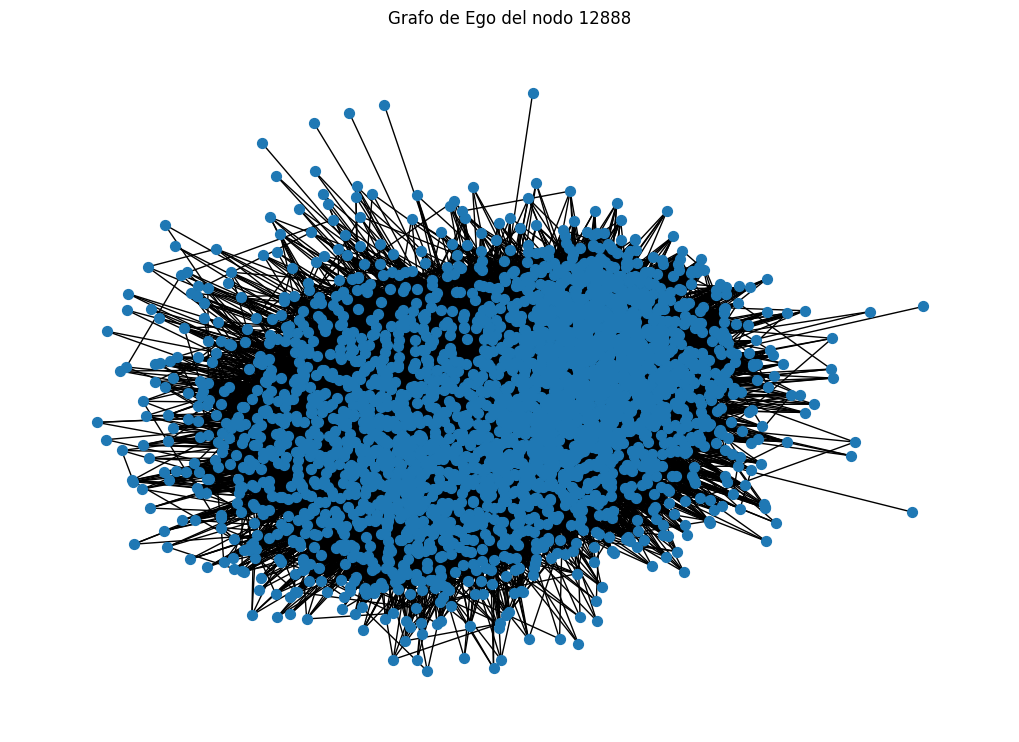

In [53]:
# Dibujar el grafo de ego
pos = nx.spring_layout(ego_graph, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(ego_graph, pos, node_size=50, edge_color="black", with_labels=False)
plt.title(f'Grafo de Ego del nodo {node}')
plt.show()

In [54]:
# Verificar la forma de las features
print(data.x.shape)  # Devuelve (num_nodos, num_features)

# Obtener las features del nodo con más conexiones
features_max_degree_node = data.x[node]
print(f"Features del nodo central ({node}):\n", features_max_degree_node)

torch.Size([13752, 767])
Features del nodo central (12888):
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

# **2. Análisis descriptivo**

En la siguientes líneas de código podrá encontrar todo el análisis descriptivo del gráfico en cuestión

### *Cantidad total de nodos*


In [ ]:
ego_graph.number_of_nodes()

2993

### *Cantidad total de conexiones*

In [ ]:
ego_graph.number_of_edges()

86338

### *Cantidad de subgrafos*

Primero vamos a averiguar si todos los nodos estan conectados entre sí

In [ ]:
nx.is_connected(ego_graph)

True

In [ ]:
nx.number_connected_components(ego_graph)

1

### *Promedio de conexiones de los nodos*

En promedio, un nodo esta conectado a 57 nodos

In [ ]:
np.mean([d for _, d in ego_graph.degree()])

57.69328433010357

### *Longitud de ruta más corta para todos los pares de nodos en la red*

In [ ]:
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(ego_graph))

In [ ]:
df['start_node'].unique()

array([    0,     1,     2, ..., 13749, 13750, 13751])

Se calcula la longitud de la ruta más corta entre dos nodos aleatorios. Entre el nodo 218 y el nodo 4044 la longitud más corta es de 2

In [ ]:
shortest_path_lengths[218][4044]

2

### *Diametro*

Para conectarnos de un nodo a cualquier otro tendríamos que atravesar 2 aristas o menos

Hay que tener en cuenta que el grafo no es completamente conectado razon por la cual se calcula el diametro de la componente mas grande

In [ ]:
diameter = max(nx.eccentricity(ego_graph, sp=shortest_path_lengths).values())
diameter

2

### *Promedio de la longitud del camino más corto*

A continuación se calcula el promedio de la longitud del camino más corto para todos los pares de nodos: para llegar de un nodo a otro, se atravesarán aproximadamente 1.98 aristas en promedio

In [ ]:
average_path_lengths_ = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values() if shortest_path_lengths.keys()
]
np.mean(average_path_lengths_)

1.9800557018609743

In [ ]:
print(ego_graph)

Graph with 2993 nodes and 86338 edges


### Grafico de distribuciones

Se procede a observar las distribuciones de distancias de los nodos.

Text(0, 0.5, 'Frequency (%)')

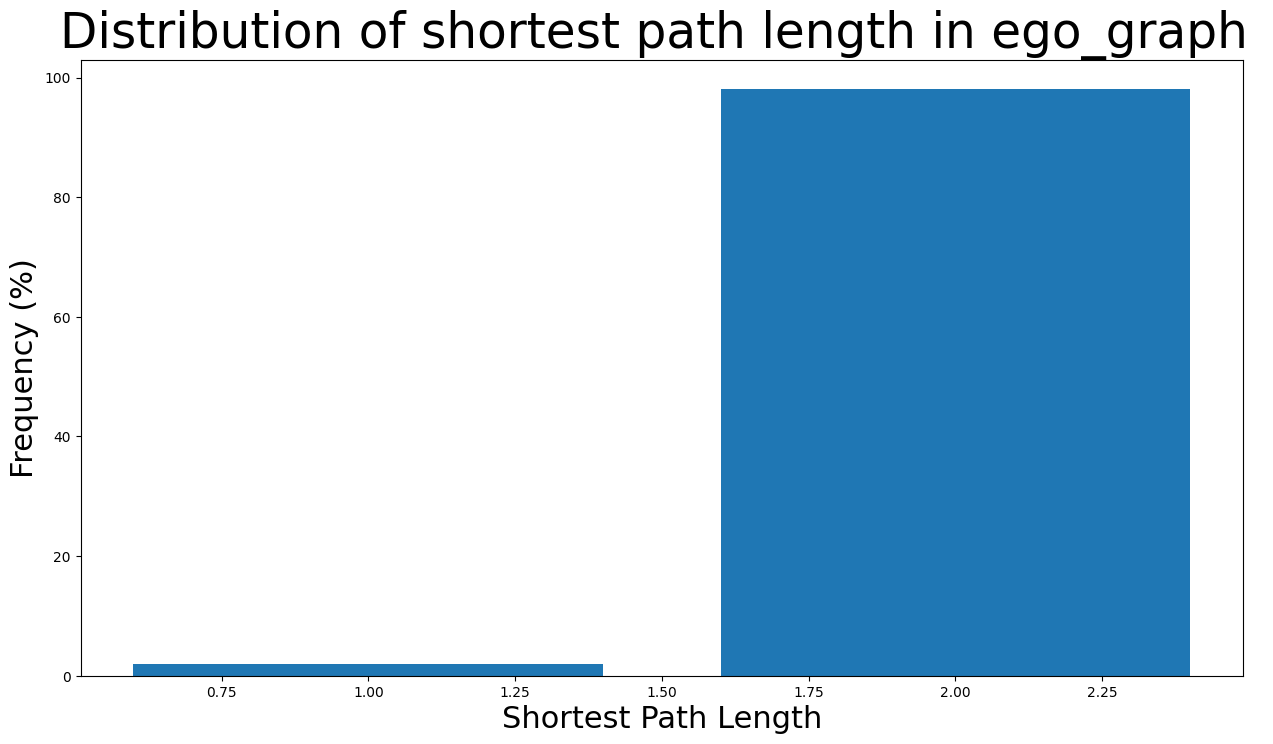

In [ ]:
# Se genera un vector con todos los posibles valores hasta el máximo (el diametro)
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extraemos la frecuencia de los caminos mas cortos entre dos nodos
for pls in shortest_path_lengths.values():
  pl, cnts = np.unique(list(pls.values()), return_counts=True)
  path_lengths[pl] += cnts

# Se calcula el porcentaje de frecuencia de distribución
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Se grafica el porcentaje de frecuencia de distribución
fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
      f"Distribution of shortest path length in ego_graph ", fontdict={"size": 35}, loc="center"
)
ax.set_xlabel("Shortest Path Length", fontdict={"size": 22})
ax.set_ylabel("Frequency (%)", fontdict={"size": 22})

Se observa que mayormente para ir de un nodo a otro se requieren de 2 nodos.


### Densidad del grafo

Total

In [ ]:
nx.density(ego_graph)

0.01928251481621109

Se muestra que en conjunto todo es disperso, al ser menor que 1 este indicador

## **Centralidad**

### Grado de centralidad

El grado de centralidad son las cantidad de conexiones o links para cada nodo. Para este caso, a mayor grado de centralidad mayor importancia tiene el nodo (posiblemente corresponde a un influencer) por su cantidad de seguidores

In [ ]:
degree_centrality = nx.centrality.degree_centrality(ego_graph)  # se guarda el resultado en una variable
(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(12888, 0.9999999999999999),
 (8210, 0.5658422459893048),
 (8140, 0.48228609625668445),
 (1524, 0.47359625668449196),
 (4528, 0.4425133689839572),
 (872, 0.3048128342245989),
 (7984, 0.2997994652406417),
 (4135, 0.2667112299465241)]

Lo anterior indica por ejemplo que el usuario 12888 tiene conexión con alrededor del 99% de toda la red. Además estos 8 nodos son los nodos destacados de la red, esto quiere decir que son los mas influyentes de Twitch

Luego, se exploran los vecinos de los nodos con mayor grado de centralidad:

En este caso, el usuario 12888 tiene 2992 nodos vecinos, en otras palabras, este usuario esta conectado a 2992 personas.

In [ ]:
(sorted(ego_graph.degree, key=lambda item: item[1], reverse=True))[:8]

[(12888, 2992),
 (8210, 1693),
 (8140, 1443),
 (1524, 1417),
 (4528, 1324),
 (872, 912),
 (7984, 897),
 (4135, 798)]

En el siguiente histograma es visible que todos de usuarios de Amazon tienen grado de centralidad inferiores a 0,1. Incluso la mayoría tiene menos de 0,05. Lo anterior, quiere decir que muchos nodos tiene centralidades de grado extremadamente bajo ya que no estan muy interconectados en la red.

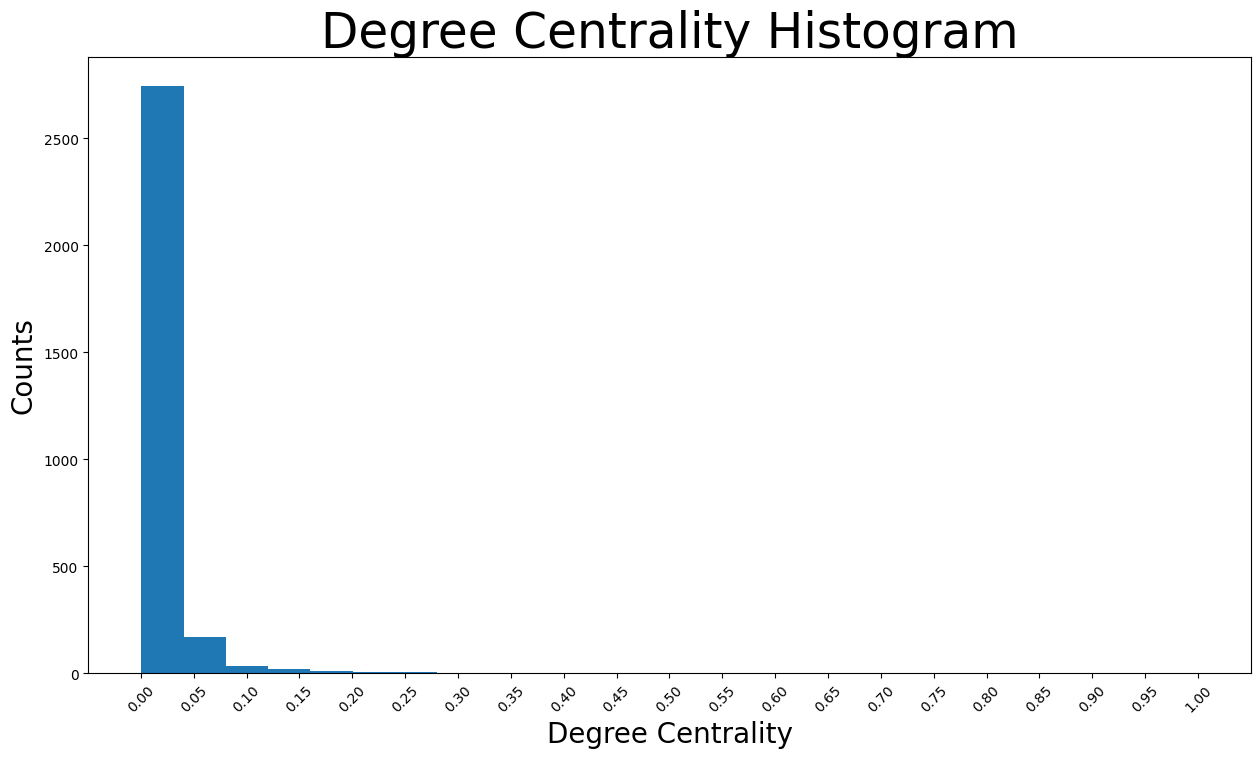

In [ ]:
# Crear el histograma
plt.figure(figsize=(15, 8))
plt.hist(degree_centrality.values(), bins=25)

# Ajustar los ticks del eje X de acuerdo a los datos
min_centrality = min(degree_centrality.values())
max_centrality = max(degree_centrality.values())
plt.xticks(ticks=[i / 100 for i in range(int(min_centrality * 100), int(max_centrality * 100) + 5, 5)], rotation=45)

# Títulos y etiquetas
plt.title("Degree Centrality Histogram", fontdict={"size": 35}, loc="center")
plt.xlabel("Degree Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

# Mostrar el gráfico
plt.show()

(-1.112069951891899,
 1.1486974829435348,
 -1.0372531881928444,
 1.1935851445794106)

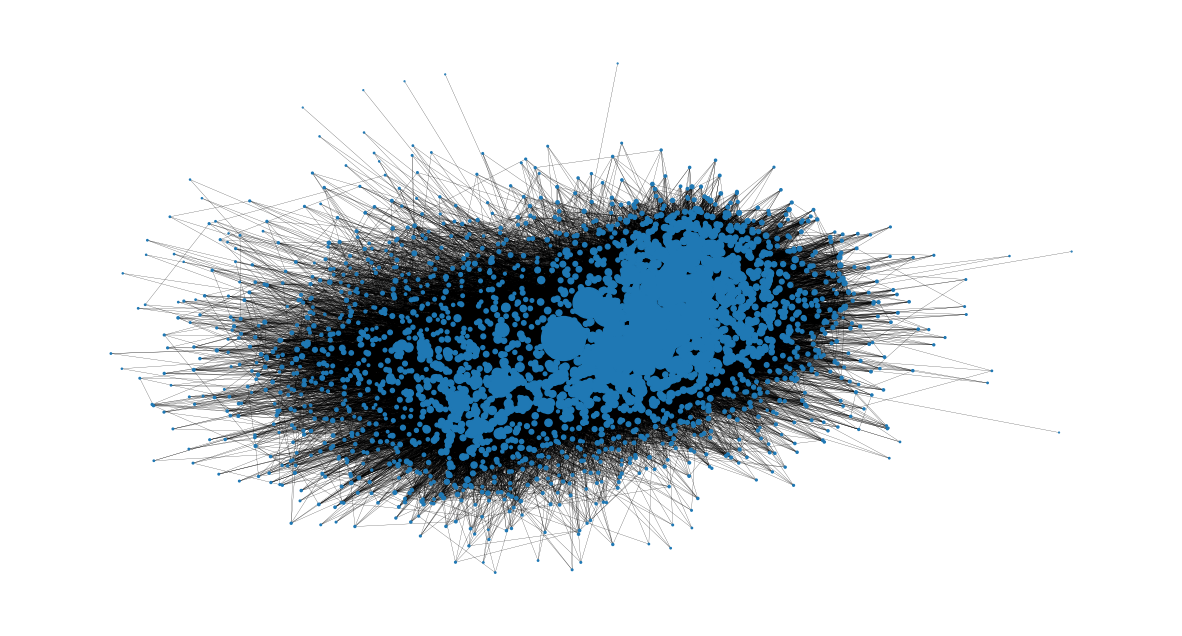

In [ ]:
node_size = [
    v * 1000 for v in degree_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(ego_graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad de intermediación

Esta métrica evalúa en que medida un nodo actúa como puente entre otros nodos, es decir, mide la cantidad de veces que un nodo se encuentra en el camino más corto entre otros nodos.
En el análisis de AMAZON se asocia con la capacidad del usuario para influir a los demás.

In [ ]:
betweenness_centrality = nx.centrality.betweenness_centrality(ego_graph
)  # se guarda el resultado en una variable
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(12888, 0.4893907570130005),
 (8210, 0.06566074729620522),
 (8140, 0.05055445073244675),
 (1524, 0.046506923465407635),
 (4528, 0.03462047334938649),
 (9251, 0.012806686194149338),
 (12475, 0.011686239287721957),
 (872, 0.011245376053075434)]

Lo anterior nos dice que los nodos 12888 y 8210 son los de mayor grado de intermediación.

Text(0, 0.5, 'Counts')

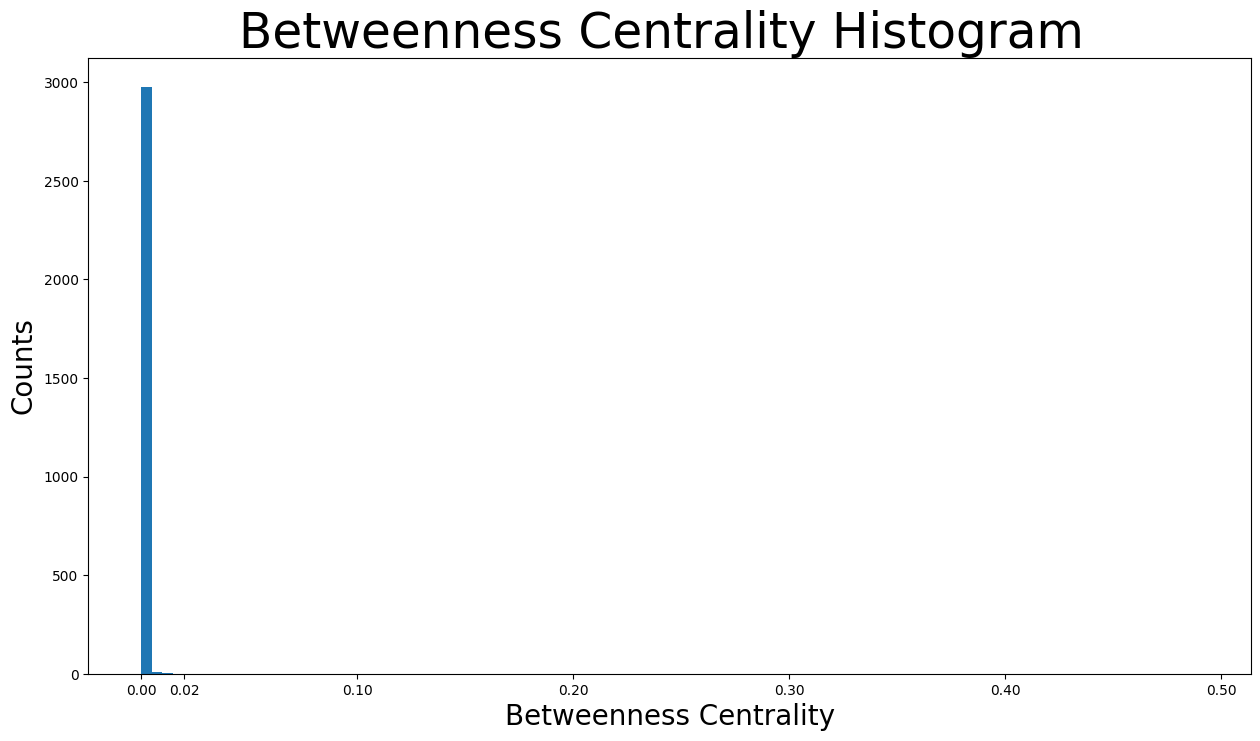

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(betweenness_centrality.values(), bins=100)
plt.xticks(ticks=[0, 0.02, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.title("Betweenness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Betweenness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Como se puede ver en el histograma de centralidad de intermediación, la gran mayoría se encuentran por debajo de 0,02 porque la gran mayoría de nodos no actúan como puentes en los caminos más cortos. Incluso, los nodos que actúan como puentes tienen centralidades de intermediación muy bajas

(-1.112069951891899,
 1.1486974829435348,
 -1.0372531881928444,
 1.1935851445794106)

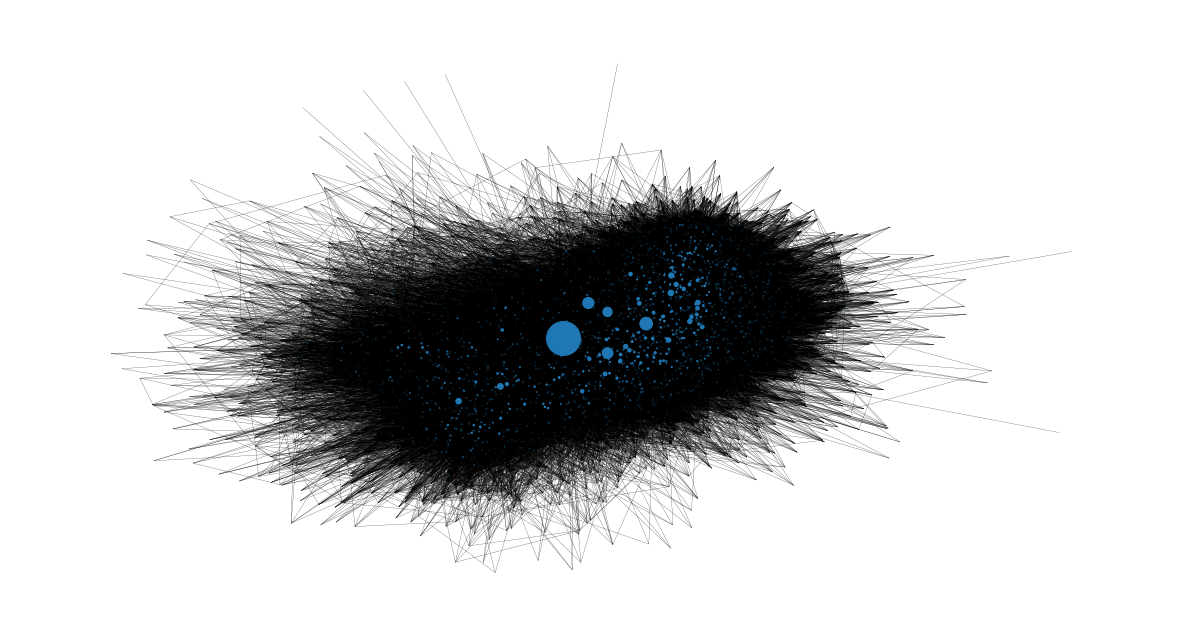

In [ ]:
node_size = [
    v * 1200 for v in betweenness_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(ego_graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

En la gráfica anterior se puede observar los nodos con mayor centralidad de intermediación. Se puede observar una concentración de nodos en el centro de la red

### Centralidad de cercanía

Cuantifíca que tan cerca esta un nodo de otro. En el contexto de Amazon, nos sirve para encontrar que personas influyen mas en los demás usuarios. Adicionalmente, un nodo con alta centralidad hace que la información se difunda con mayor velocidad

In [ ]:
closeness_centrality = nx.centrality.closeness_centrality(ego_graph
)
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

[(12888, 1.0),
 (8210, 0.697273362852482),
 (8140, 0.658885707993834),
 (1524, 0.6551346617035253),
 (4528, 0.6420600858369099),
 (872, 0.5899053627760252),
 (7984, 0.5881659131118537),
 (4135, 0.5769379097570382)]

Los nodos con mayor centralidad de cercanía son 12888 y 8210. Entre los 8 nodos con mayor centralidad de cercanía no existe una gran brecha entre ellos.

Se calcula el promedio de la distancia de un nodo a cualquiera de los otros

In [ ]:
1 / closeness_centrality[218]

1.915106951871658

Text(0, 0.5, 'Counts')

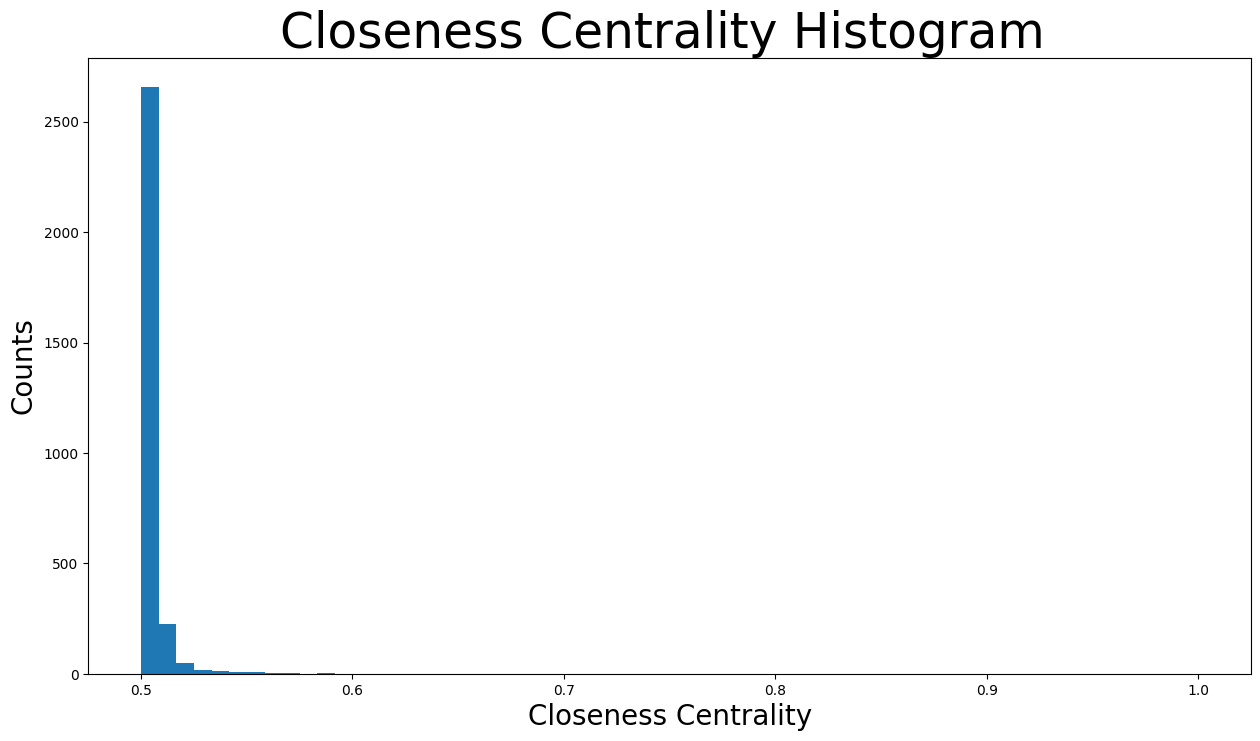

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(closeness_centrality.values(), bins=60)
plt.title("Closeness Centrality Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Closeness Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

Según el histograma de centralidad de cercanía la mayoría de nodos tiene una centralidad de cercanía entre 0,5 a 0,6. Esto nos dice que la mayoria de nodos estan medianamente cerca del centro de la red y a otros nodos en general.

(-1.112069951891899,
 1.1486974829435348,
 -1.0372531881928444,
 1.1935851445794106)

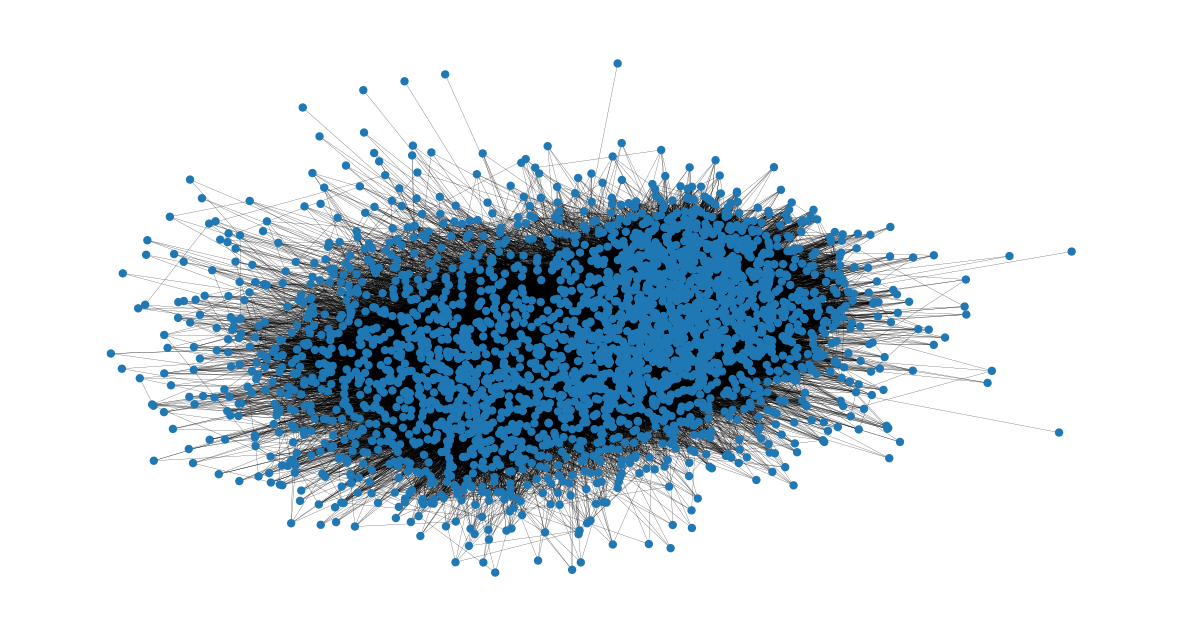

In [ ]:
node_size = [
    v * 50 for v in closeness_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(ego_graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

### Centralidad del vector propio

Esta medida puede identificar los nodos con mayor influencia en toda la red. Una centralidad de vector propio alta significa que el nodo está conectado a otros nodos que a su vez tienen centralidades de vector propio altas. En este análisis, significa la capacidad de los usuarios para influir en todo el gráfico.

Los diez nodos con mayor centralidad del vector propio son:

In [ ]:
eigenvector_centrality = nx.centrality.eigenvector_centrality(ego_graph
)
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[(12888, 0.23382912824510202),
 (8210, 0.18368043558942598),
 (4528, 0.15491060841224827),
 (8140, 0.14946135685694192),
 (1524, 0.14887710402897675),
 (872, 0.11786290103185298),
 (7984, 0.11009821803997255),
 (2138, 0.10408506279733336),
 (4135, 0.10402903482502894),
 (10610, 0.10302725743299232)]

A continuación, se comprueba si los nodos del 2 al 10 están conectados al nodo más importante

In [ ]:
high_eigenvector_centralities = (
    sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)
)[
    1:10
]  # 2 a 10 nodos con mayor eigen value
high_eigenvector_nodes = [
    tuple[0] for tuple in high_eigenvector_centralities
]
neighbors_218 = [n for n in G.neighbors(218)]  #lista con todos los nodos
all(
    item in neighbors_218 for item in high_eigenvector_nodes
)  # verificar si tiene conexiones con el neighbor_218

False

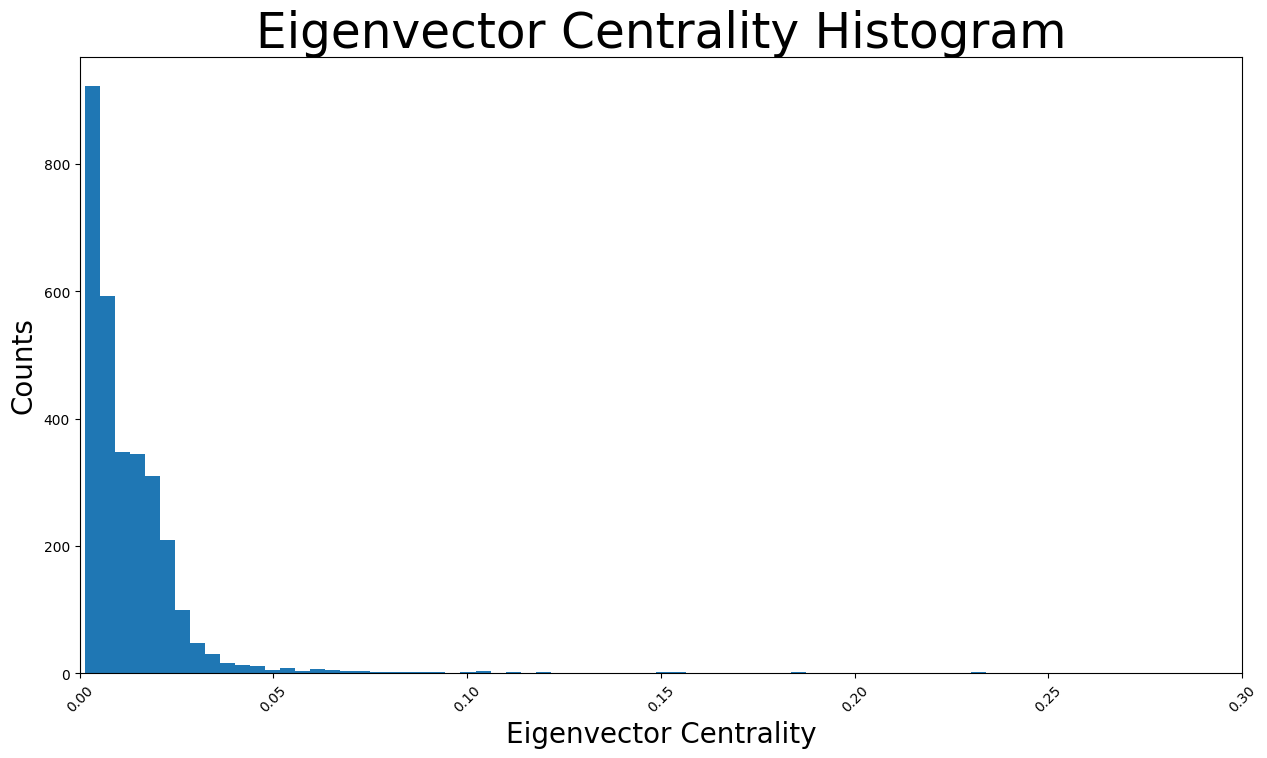

In [ ]:
# Crear el histograma
plt.figure(figsize=(15, 8))
plt.hist(eigenvector_centrality.values(), bins=60)

# Obtener el rango de los valores para definir los ticks en el eje X
min_eigenvector = min(eigenvector_centrality.values())
max_eigenvector = max(eigenvector_centrality.values())

# Establecer límites del eje X
plt.xlim(min_eigenvector, max_eigenvector)

# Crear ticks más apropiados para el rango de centralidad de eigenvector
# Aquí estamos generando una lista de ticks con pasos adecuados
ticks = [i / 100 for i in range(int(min_eigenvector * 100), int(max_eigenvector * 100) + 10, 5)]
plt.xticks(ticks, rotation=45)  # Rotar las etiquetas para mejorar la legibilidad

# Títulos y etiquetas
plt.title("Eigenvector Centrality Histogram", fontdict={"size": 35}, loc="center")
plt.xlabel("Eigenvector Centrality", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

# Mostrar el gráfico
plt.show()

Como se muestra en el histograma la mayoría de valores se encuentran por debajo de 0,05 lo que significa que son muy cercanos a 0

(-1.112069951891899,
 1.1486974829435348,
 -1.0372531881928444,
 1.1935851445794106)

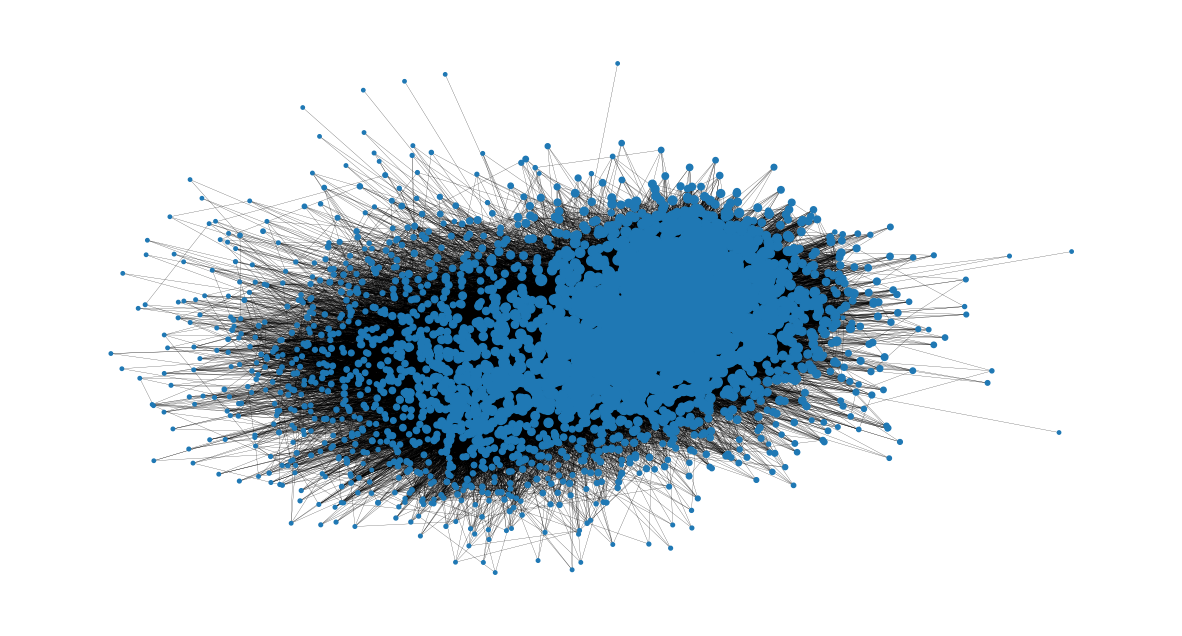

In [ ]:
node_size = [
    v * 4000 for v in eigenvector_centrality.values()
]
plt.figure(figsize=(15, 8))
nx.draw_networkx(ego_graph, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")

Del gráfico anterior se puede observar que la mayor cantidad de eigenvalues se Encuentran no en un cúmulo central y pocos hacia afuera de la red

## **Segregación**

### Coeficiente de agrupación


El coeficiente de agrupamiento promedio es la media de los coeficientes de agrupamiento de todos los nodos lo que nos da como resultado que cuanto mas cerca este el coeficiente a 1 mas completo el gráfico será. Es dcir, un coeficiente de agrupación promedio alto indica que el grafo o subgrafo tiene una alta densidad de conexiones locales, lo que sugiere una red con fuertes agrupaciones o comunidades de nodos.

In [ ]:
nx.average_clustering(ego_graph)

0.42571439352385

Text(0, 0.5, 'Counts')

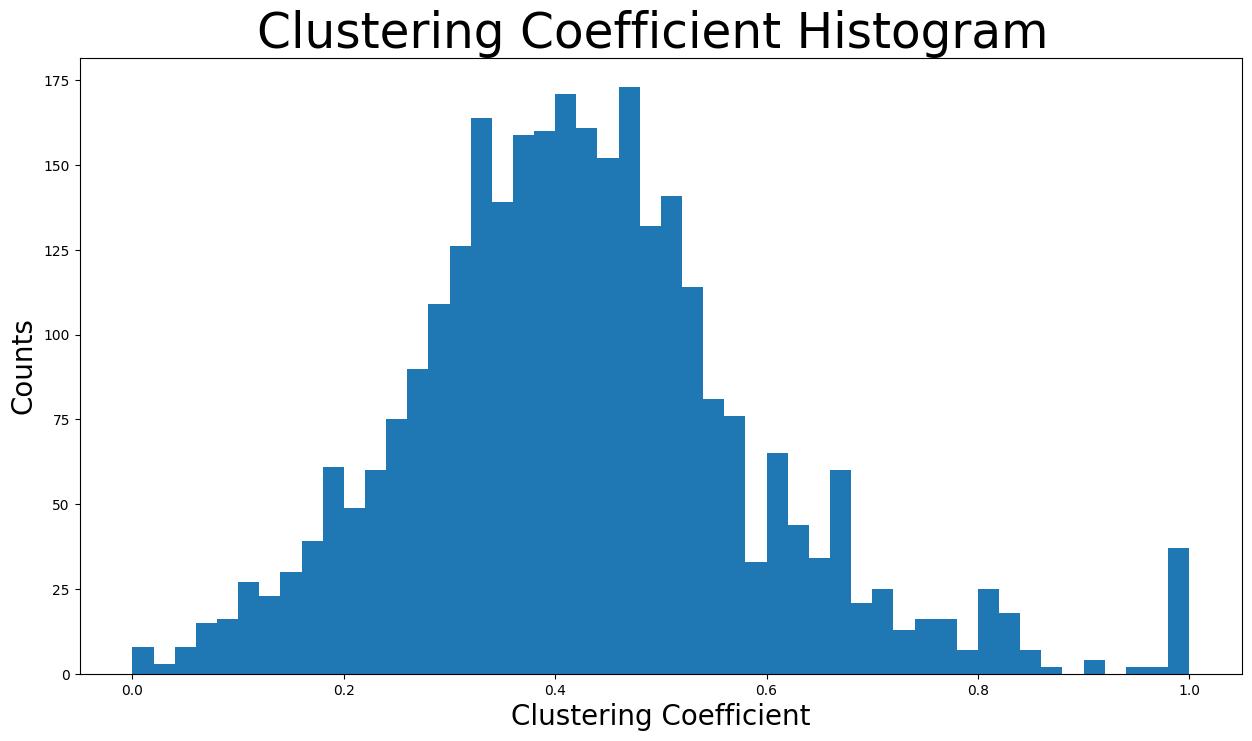

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(nx.clustering(ego_graph).values(), bins=50)
plt.title("Clustering Coefficient Histogram ", fontdict={"size": 35}, loc="center")
plt.xlabel("Clustering Coefficient", fontdict={"size": 20})
plt.ylabel("Counts", fontdict={"size": 20})

La partición mas grande del histográma se encuentra en el 0,4 y son mas de 160. El resto de nodos se encuentra mayormente entre 0,3 y 0,5.

A continuación se calculará el número único de triangulos de la red

In [ ]:
triangles_per_node = list(nx.triangles(ego_graph).values())
sum(
    triangles_per_node
) / 3

826648.0

Luego, el promedio de triangulos a los que un nodo pertenece

In [ ]:
np.mean(triangles_per_node)

828.5813564984965

Con el fin de eliminar los atípicos la mediana nos podría indicar a cuantos triangulos pertenece un nodo.

In [ ]:
np.median(triangles_per_node)

244.0

Ya que el promedio es de 828 y la mediana es 244, significa que la mayoría de los nodos pertenecen a muy pocos triangulos, mientras que, otros pertenecen a muchos triangulos

### Transitividad

La transitividad cuantifica la presencia de grupos de nodos interconectados o también llamado comunidades. A continuación se calcula la transitividad.

In [ ]:
nx.transitivity(ego_graph)

0.11362311424897183

0.11 es un valor bajo de transitividad e indica que la red tiene una estructura más fragmentada y menos agrupaciones de nodos interconectados.

### Puentes

Una conexión entre dos nodos A y B en el gráfico se considera un puente, si se elimina causaría que A y B se encuentren en dos componentes diferentes. A continuación se mira si hay puentes

In [ ]:
nx.has_bridges(ego_graph)

True

In [ ]:
bridges = list(nx.bridges(ego_graph))
len(bridges)

7

Hay 7 puentes.

habiendo conocido los puentes se calcularán los puentes locales que son dos nodos que no tienen seguidores en común y además son puntos finales

La ausencia de puentes locales sugiere que la red está fuertemente segmentada en comunidades o grupos aislados, y que los nodos dentro de cada grupo están más conectados entre sí que con nodos fuera de su grupo.

In [ ]:
local_bridges = list(nx.local_bridges(ego_graph, with_span=False))
len(local_bridges)

7

En la siguiente visualización vemos el gráfico donde se muestran los puentes en color rojo y los puentes locales en verde

(-1.112069951891899,
 1.1486974829435348,
 -1.0372531881928444,
 1.1935851445794106)

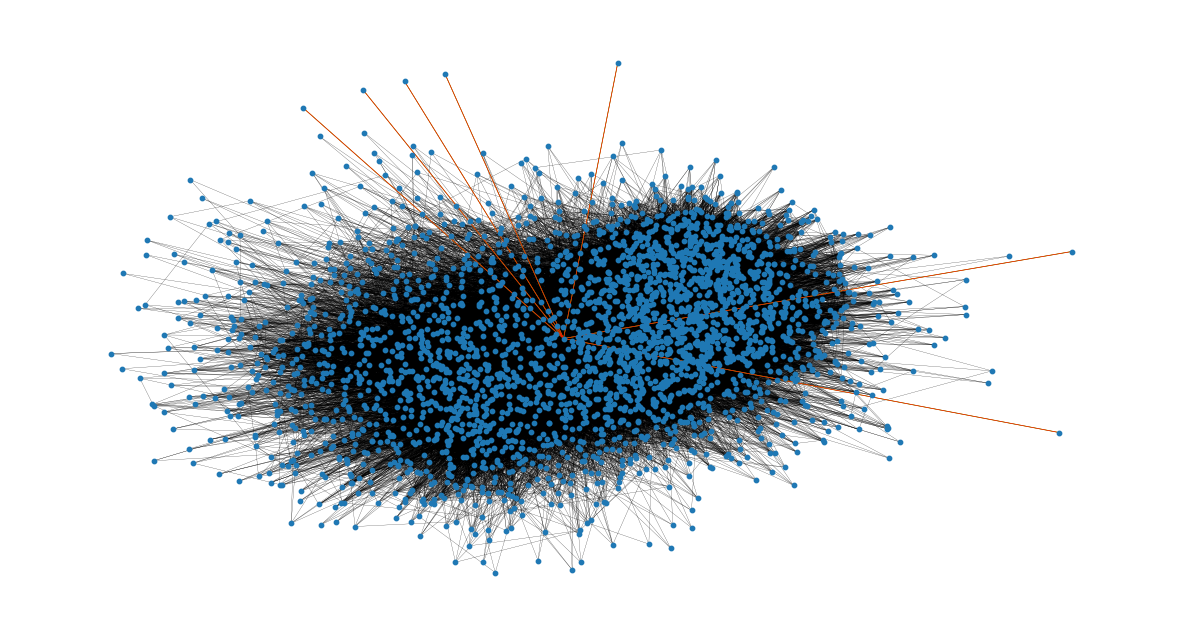

In [ ]:
plt.figure(figsize=(15, 8))
nx.draw_networkx(ego_graph, pos=pos, node_size=10, with_labels=False, width=0.15)
nx.draw_networkx_edges(
    ego_graph, pos, edgelist=local_bridges, width=0.5, edge_color="lawngreen"
)  # green color for local bridges
nx.draw_networkx_edges(
    ego_graph, pos, edgelist=bridges, width=0.5, edge_color="r"
)  # red color for bridges
plt.axis("off")

## **Métricas de resiliencia**

### Coeficiente de asortatividad

Es la preferencia de nodos a adherirse a otros nodos.
Hay dos formas de calcular esta asortatividad

In [ ]:
nx.degree_assortativity_coefficient(ego_graph)

-0.14922032145553127

In [ ]:
nx.degree_pearson_correlation_coefficient(
    ego_graph
)  # use the potentially faster scipy.stats.pearsonr function.

-0.1492203214555315

El coeficiente resultante sugiere que la red es disasortativa. En una red disasortativa, los nodos tienden a conectarse con otros nodos que tienen características diferentes o contrastantes en lugar de características similares. En otras palabras, los nodos con ciertas propiedades tienden a estar conectados a nodos que tienen propiedades diferentes.

Las personas con diferentes intereses, edades o ubicaciones geográficas tienden a conectarse más entre sí en lugar de con personas que comparten características similares.

## **Network Communities**


A continuación, se realizará con el segundo método con el algoritmo de comunidades fluidas asincronas.

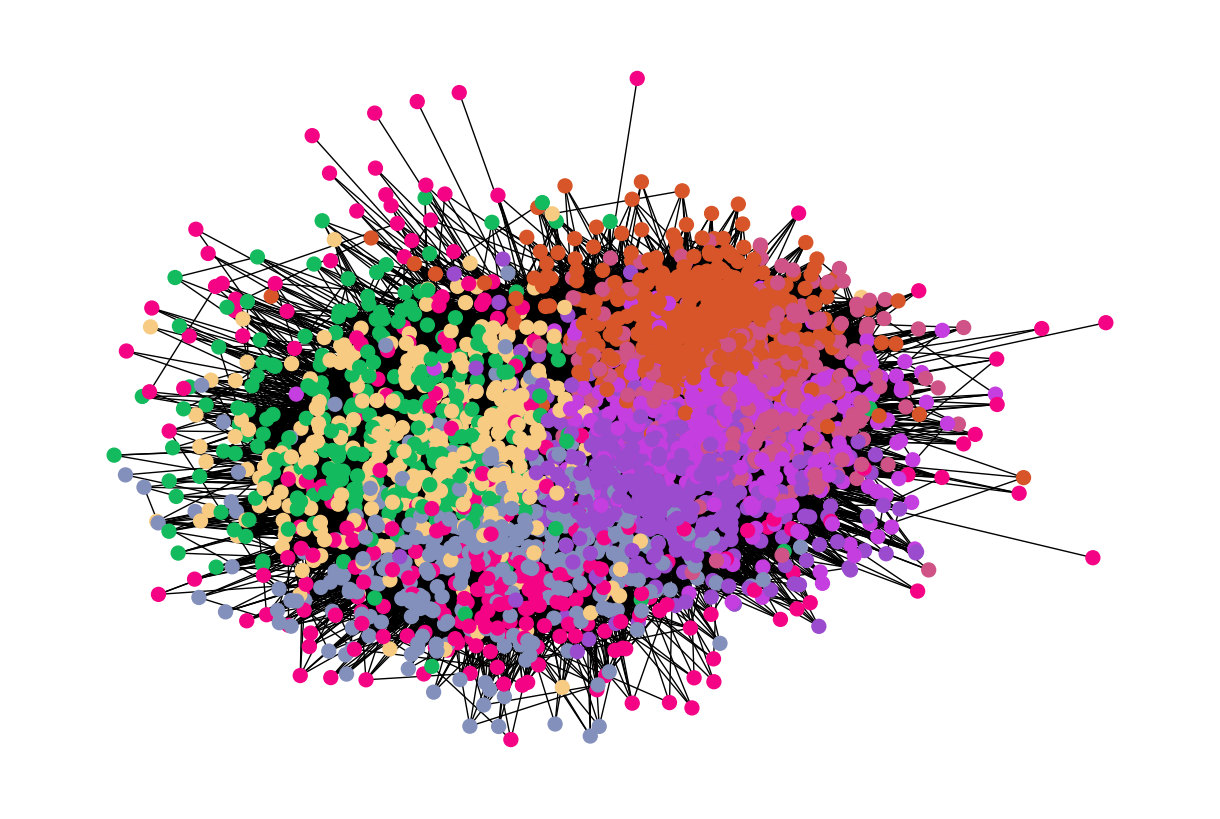

In [ ]:
# Crear un diccionario para almacenar los colores de los nodos
colors = {}

# Asignar colores a las comunidades detectadas
counter = 0
for com in nx.community.asyn_fluidc(ego_graph, 8, seed=0):
    color = "#%06X" % randint(0, 0xFFFFFF)  # Crear color RGB aleatorio
    counter += 1
    for node in com:
        colors[node] = color

# Obtener los colores en el mismo orden que los nodos del grafo
node_colors = [colors.get(node, "#000000") for node in ego_graph.nodes()]  # Color negro por defecto

# Dibujar el grafo con los colores asignados
pos = nx.spring_layout(ego_graph, seed=42)
plt.figure(figsize=(12, 8))
nx.draw(ego_graph, pos, node_color=node_colors, with_labels=False, node_size=100)
plt.show()

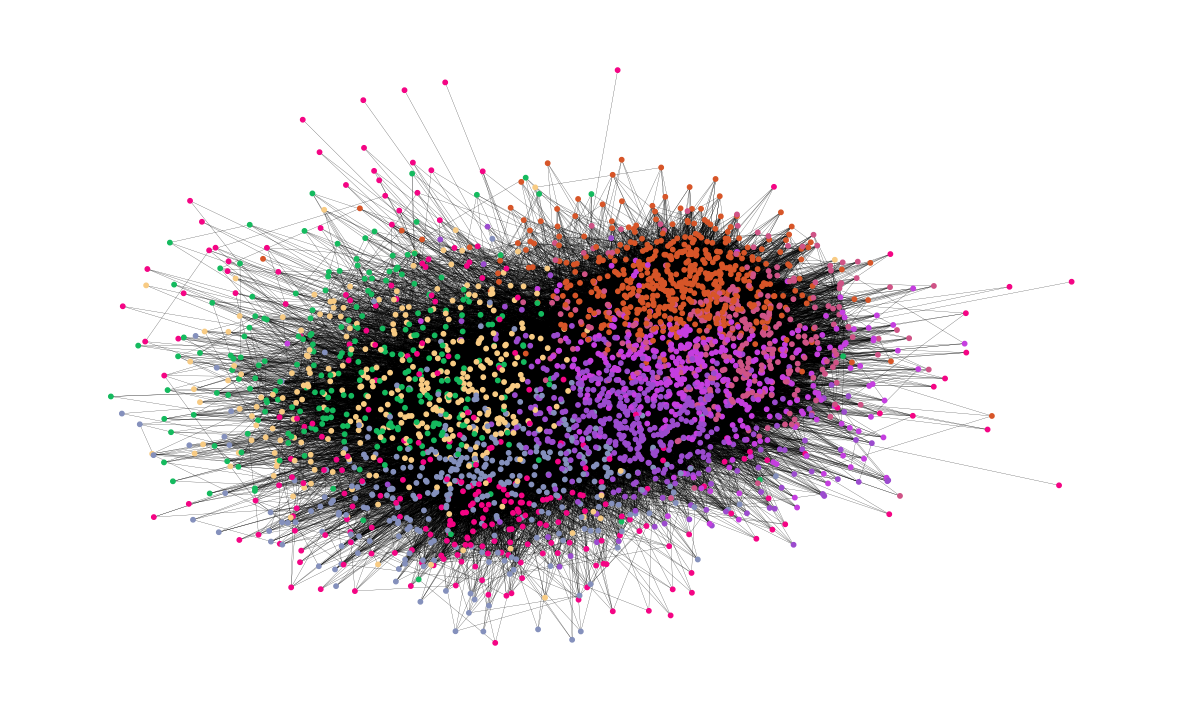

In [ ]:
# Obtener los colores de los nodos en el mismo orden que los nodos del grafo
node_colors = [colors.get(node, "#000000") for node in ego_graph.nodes()]  # Negro por defecto si no se encuentra el nodo

# Dibujar el grafo
plt.figure(figsize=(15, 9))
plt.axis("off")
nx.draw_networkx(
    ego_graph, pos=pos, node_size=10, with_labels=False, width=0.15, node_color=node_colors
)
plt.show()

# **3. Prepraración de la data**

En las siguientes líneas se podrá observar los diversos métodos con los cuales fueron traducidos los grafos a números para que puedan ser entendidos por los modelos

## ***3.1 Matriz de Adyacencia***

In [14]:
edge_index_list = pd.DataFrame(data.edge_index.numpy().T, columns=['start_node','end_node'])

In [15]:
from torch_geometric.utils import to_dense_adj

adjacency = to_dense_adj(data.edge_index)[0]
adjacency += torch.eye(len(adjacency))
adjacency.cpu().numpy()

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## ***3.2 Node2Vec***

In [16]:
!pip install node2vec
!pip install -q node2vec
#!pip install -qI gensim

In [17]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)

def next_node(previous, current, p, q):
    alphas = []

    # Get the neighboring nodes
    neighbors = list(ego_graph.neighbors(current))

    # Calculate the appropriate alpha value for each neighbor
    for neighbor in neighbors:
        # Distance = 0: probability to return to the previous node
        if neighbor == previous:
            alpha = 1/p
        # Distance = 1: probability of visiting a local node
        elif G.has_edge(neighbor, previous):
            alpha = 1
        # Distance = 2: probability to explore an unknown node
        else:
            alpha = 1/q
        alphas.append(alpha)

    # Normalize the alpha values to create transition probabilities
    probs = [alpha / sum(alphas) for alpha in alphas]

    # Randomly select the new node based on the transition probabilities
    next = np.random.choice(neighbors, size=1, p=probs)[0]
    return next

In [18]:
def random_walk(start, length, p, q):
    walk = [start]

    for i in range(length):
        current = walk[-1]
        previous = walk[-2] if len(walk) > 1 else None
        next = next_node(previous, current, p, q)
        walk.append(next)

    return walk

Se debe activa GPU para que crgue rápido el código

Adicional se hace un grafo de ego mas pequeño para realizar modelos debido a la capacidad de computo

In [ ]:
import gensim
import networkx as nx
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random

#walks = []
#num_walks = 1
#walk_length = 5
#p = 2.0
#q = 3

#for _ in range(num_walks):
#    for node in ego_graph.nodes:
#        walk = random_walk(node, walk_length, p, q)
#        walks.append(walk)

# Create and train Word2Vec for DeepWalk
#node2vec = Word2Vec(walks,
#                hs=1,   # Hierarchical softmax
#                sg=1,   # Skip-gram
#                vector_size=10,
#                window=5,
#                workers=2,
#                min_count=1,
#                seed=0)
#node2vec.train(walks, total_examples=node2vec.corpus_count, epochs=30, report_delay=1)

In [ ]:
#node_count = node2vec.corpus_count
#embedding_size = node2vec.vector_size
#print('Número de nodos:', node_count)
#print('Tamaño del embedding:', embedding_size)

No se va a realizar el node2vec debido a capacidad de computo y se trabara directamente con las matrices de las features de los nodos.

# **4. Modelación**

A continuación se presenta la modelación al problema planteado, dentro del cual se tiene:
- Sistema de recomendación
- Clasificación de usuarios para saber si emplean lenguaje explícito o no, mediante:

    1.   Regresión Logística
    2.   Random Forest
    3.   Red Neuronal
    4.   CNN
    5.   Modelos de atención



## ***4.1 Sistema de recomendación***

In [55]:
from sklearn.metrics.pairwise import cosine_similarity

# Obtener la matriz de features de los nodos
X = data.x.numpy()  # (num_nodos, num_features)

# Calcular la matriz de similitud de coseno
similarity_matrix = cosine_similarity(X)

# Generar recomendaciones para un nodo específico
def recommend_nodes(node_id, top_k=5):
    # Obtener las similitudes del nodo actual con todos los demás nodos
    node_similarities = similarity_matrix[node_id]

    # Ordenar nodos por similitud (excepto el nodo actual)
    similar_nodes = np.argsort(-node_similarities)[1:top_k+1]

    # Mostrar los nodos recomendados y sus puntuaciones de similitud
    recommendations = [(node, node_similarities[node]) for node in similar_nodes]
    return recommendations

# Ejemplo: obtener recomendaciones para el nodo con el mayor grado
node_id = node  # Nodo central que seleccionaste previamente
top_recommendations = recommend_nodes(node_id)

print(f"Recomendaciones para el nodo {node_id}:")
for idx, (node, score) in enumerate(top_recommendations):
    print(f"{idx+1}. Nodo {node} - Similitud: {score:.4f}")

Recomendaciones para el nodo 12888:
1. Nodo 11431 - Similitud: 0.9954
2. Nodo 1291 - Similitud: 0.9948
3. Nodo 13480 - Similitud: 0.9948
4. Nodo 4386 - Similitud: 0.9948
5. Nodo 11395 - Similitud: 0.9948


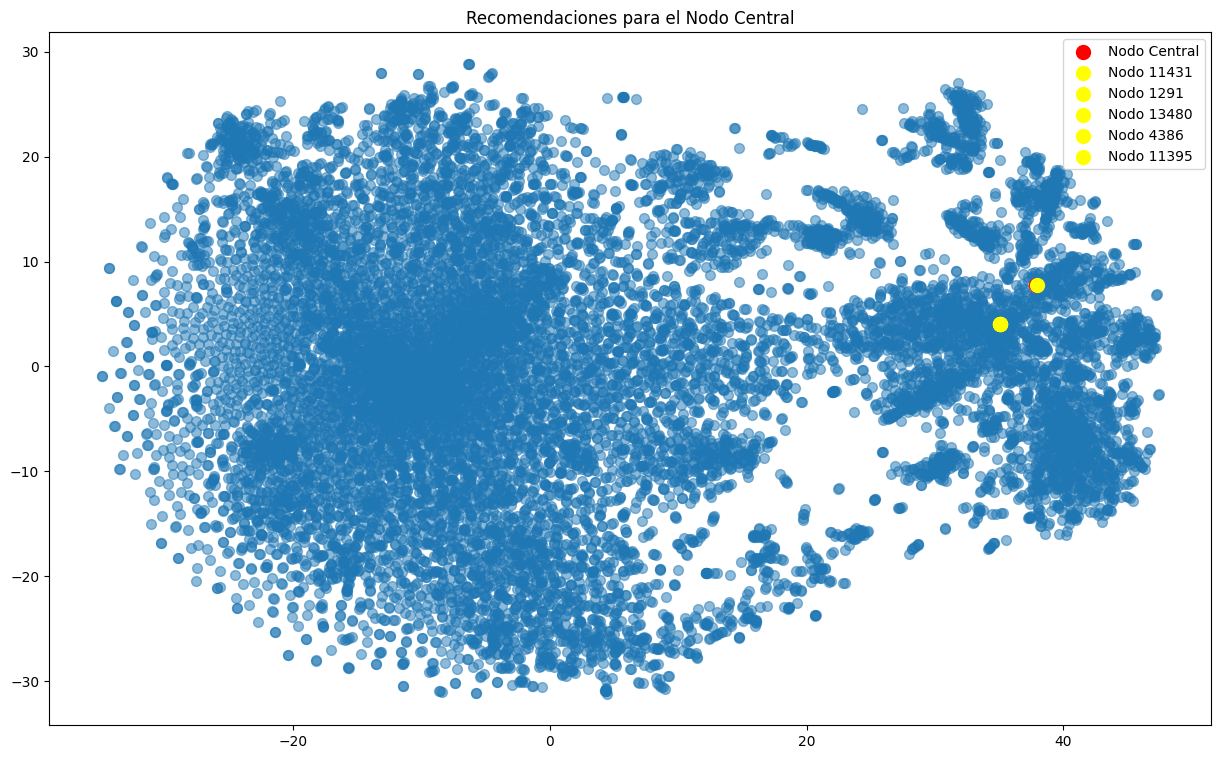

In [56]:
from sklearn.manifold import TSNE

# Visualizar el nodo central y sus recomendaciones
tsne = TSNE(n_components=2, random_state=0).fit_transform(X)

plt.figure(figsize=(15, 9))
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, alpha=0.5)
plt.scatter(tsne[node_id, 0], tsne[node_id, 1], color='red', s=100, label="Nodo Central")

for node, _ in top_recommendations:
    plt.scatter(tsne[node, 0], tsne[node, 1], color='yellow', s=100, label=f"Nodo {node}")

plt.legend()
plt.title("Recomendaciones para el Nodo Central")
plt.show()

## ***4.2 Clasificación de usuarios***

Se generan los datos de entrenamiento y prueba con las matrices de las features de los nodos

### *4.2.1 Regresión Logística*

#### **Modelo**

In [76]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convertir las features y etiquetas a numpy arrays
X = data.x.numpy()  # Matriz de features (num_nodos, num_features)
y = data.y.numpy()  # Etiquetas (num_nodos,)

# División de datos en entrenamiento y prueba
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [77]:
rl_param_grid = ParameterGrid(
    {
    'penalty': ['l1','l2'],
    'C': [0.01, 0.1],
    'max_iter': [1000, 2000],
}
)

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score, classification_report

# Variables para almacenar el mejor modelo y su desempeño
best_model = None
best_score = 0
best_params = None

# Iterar sobre cada combinación de hiperparámetros
for params in rl_param_grid:
    print(f"Entrenando con hiperparámetros: {params}")

    # Crear el modelo con los hiperparámetros actuales
    model = LogisticRegression(
        penalty=params['penalty'],
        C=params['C'],
        max_iter=params['max_iter'],
        solver='liblinear' if params['penalty'] == 'l1' else 'lbfgs',
        random_state=42
    )

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Evaluar el modelo en el conjunto de validación
    val_score = model.score(X_val, y_val)
    print(f"Accuracy en validación: {val_score:.4f}")

    # Guardar el mejor modelo
    if val_score > best_score:
        best_score = val_score
        best_model = model
        best_params = params

# Evaluar el mejor modelo en el conjunto de prueba
test_score = best_model.score(X_test, y_test)
print(f"\nMejores hiperparámetros: {best_params}")
print(f"Accuracy en prueba: {test_score:.4f}")

Entrenando con hiperparámetros: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l1'}
Accuracy en validación: 0.7258
Entrenando con hiperparámetros: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}
Accuracy en validación: 0.8429
Entrenando con hiperparámetros: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l1'}
Accuracy en validación: 0.7258
Entrenando con hiperparámetros: {'C': 0.01, 'max_iter': 2000, 'penalty': 'l2'}
Accuracy en validación: 0.8429
Entrenando con hiperparámetros: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1'}
Accuracy en validación: 0.8495
Entrenando con hiperparámetros: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2'}
Accuracy en validación: 0.8415
Entrenando con hiperparámetros: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l1'}
Accuracy en validación: 0.8495
Entrenando con hiperparámetros: {'C': 0.1, 'max_iter': 2000, 'penalty': 'l2'}
Accuracy en validación: 0.8415

Mejores hiperparámetros: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1'}
Accuracy en prueba: 0.8612


#### **Matriz de adyacencia**

In [79]:
# Convertir las features y la matriz de adyacencia a numpy
X = data.x.numpy()  # Features de los nodos (num_nodos, num_features)
A = adjacency.cpu().numpy()  # Matriz de adyacencia (num_nodos, num_nodos)

# Concatenar las features con la matriz de adyacencia
X_augmented = np.concatenate([X, A], axis=1)
print("Nueva forma de las features:", X_augmented.shape)

Nueva forma de las features: (13752, 14519)


In [80]:
from sklearn.model_selection import GridSearchCV

# Dividir los datos en entrenamiento, validación y prueba
X_train, X_val_test, y_train, y_val_test = train_test_split(X_augmented, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Definir los parámetros para la búsqueda
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1],
    'max_iter': [1000, 2000],
    'solver': ['liblinear']  # 'liblinear' soporta L1 y L2
}

# Configurar la búsqueda de hiperparámetros
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_model = grid_search.best_estimator_

# Evaluar el modelo en el conjunto de prueba
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Mejor modelo: {best_model}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")

Mejor modelo: LogisticRegression(C=0.1, max_iter=1000, random_state=42, solver='liblinear')
Accuracy en prueba: 0.9019


### *4.2.2 Random Forest*

#### **Modelo**

Optimización de hiperparametros

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convertir las features y etiquetas a numpy arrays
X = data.x.numpy()  # Matriz de features (num_nodos, num_features)
y = data.y.numpy()  # Etiquetas (num_nodos,)

# División de datos en entrenamiento y prueba
X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val,X_test, y_val,y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [82]:
from sklearn.model_selection import ParameterGrid, cross_val_score

# Define tu conjunto de hiperparámetros para Random Forest
rf_param_grid = ParameterGrid(
    {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, None],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['sqrt', 'log2']
    }
)

In [83]:
from sklearn.ensemble import RandomForestClassifier

# Variables para almacenar el mejor modelo y el mejor accuracy
best_model = None
best_score = 0

# Búsqueda de hiperparámetros
for params in rf_param_grid:
    # Inicializar el modelo Random Forest con los parámetros actuales
    model = RandomForestClassifier(random_state=42, **params)

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Actualizar el mejor modelo si se encuentra un mejor accuracy
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_model = model
        best_params = params

# Evaluar el mejor modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Mejores parámetros:", best_params)
print(f"Accuracy en validación: {best_score:.4f}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy en validación: 0.7978
Accuracy en prueba: 0.8169


#### **Matriz de adyacencia**

In [86]:
# Convertir las features y la matriz de adyacencia a numpy
X = data.x.numpy()  # Features de los nodos (num_nodos, num_features)
A = adjacency.cpu().numpy()  # Matriz de adyacencia (num_nodos, num_nodos)

# Concatenar las features con la matriz de adyacencia
X_augmented = np.concatenate([X, A], axis=1)
print("Nueva forma de las features:", X_augmented.shape)

Nueva forma de las features: (13752, 14519)


In [87]:
# División de datos en entrenamiento, validación y prueba
X_train, X_val_test, y_train, y_val_test = train_test_split(X_augmented, y, test_size=0.20, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

In [88]:
# Variables para almacenar el mejor modelo y el mejor accuracy
best_model = None
best_score = 0

# Búsqueda de hiperparámetros
for params in rf_param_grid:
    # Inicializar el modelo Random Forest con los parámetros actuales
    model = RandomForestClassifier(random_state=42, **params)

    # Entrenar el modelo con los datos de entrenamiento
    model.fit(X_train, y_train)

    # Evaluar el modelo en el conjunto de validación
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)

    # Actualizar el mejor modelo si se encuentra un mejor accuracy
    if val_accuracy > best_score:
        best_score = val_accuracy
        best_model = model
        best_params = params

# Evaluar el mejor modelo en el conjunto de prueba
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

print("Mejores parámetros:", best_params)
print(f"Accuracy en validación: {best_score:.4f}")
print(f"Accuracy en prueba: {test_accuracy:.4f}")

Mejores parámetros: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy en validación: 0.8022
Accuracy en prueba: 0.8292


### *4.2.3 GCN*

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import numpy as np

# Convertir las features y etiquetas a numpy arrays
X = data.x.numpy()  # Matriz de features (num_nodos, num_features)
y = data.y.numpy()  # Etiquetas (num_nodos,)

# División de datos en entrenamiento y prueba
X_train, X_val_test, y_train, y_val_test, idx_train, idx_val_test = train_test_split(
    X, y, np.arange(len(X)), test_size=0.20, random_state=42, stratify=y)
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_val_test, y_val_test, idx_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

# Crear máscaras para entrenamiento, validación y prueba
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True

# Actualizar el objeto data con las nuevas máscaras
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Obtener el número de clases
num_classes = len(torch.unique(data.y))  # Número de clases en el dataset

# Definir el grid de hiperparámetros
gcn_param_grid = ParameterGrid(
    {
        'activacion': ["relu", "tanh"],
        'dropout': [0.4, 0.5],
    }
)
capas = [3, 4]  # Número de capas GCN

def accuracy(y_pred, y_true):
    """Calcular precisión."""
    return (y_pred == y_true).sum().item() / y_true.size(0)

class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers, activacion, dropout):
        super(GCN, self).__init__()
        self.activacion = activacion
        self.dropout = dropout

        # Definir las capas GCN
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(num_features, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(GCNConv(hidden_channels, hidden_channels))
        self.convs.append(GCNConv(hidden_channels, num_classes))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs) - 1:  # No aplicar activación y dropout en la última capa
                if self.activacion == 'relu':
                    x = F.relu(x)
                elif self.activacion == 'tanh':
                    x = torch.tanh(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # Devolver logits

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:.2f}% | '
                      f'Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        return acc

# Almacenar los resultados
resultados_gcn = {'params': [], 'Capas': [], 'Accuracy en test': []}

# Bucle para ajustar el modelo con cada combinación de hiperparámetros
for num_layers in capas:
    for params in gcn_param_grid:
        print(f"Entrenando modelo con {num_layers} capas, activación {params['activacion']}, dropout {params['dropout']}")

        model = GCN(
            num_features=data.num_features,  # Usa las características del dataset
            hidden_channels=16,  # Puedes ajustar el número de canales ocultos
            num_classes=num_classes,  # Usa el número de clases del dataset
            num_layers=num_layers,
            activacion=params['activacion'],
            dropout=params['dropout']
        )

        # Entrenar el modelo
        model.fit(data, epochs=200)

        # Evaluar el modelo
        acc = model.test(data)
        resultados_gcn['params'].append(params)
        resultados_gcn['Capas'].append(num_layers)
        resultados_gcn['Accuracy en test'].append(acc)

        print(f"Accuracy en test: {acc*100:.2f}%\n")

# Mostrar los resultados
for i in range(len(resultados_gcn['Accuracy en test'])):
    print(f"Modelo {i+1}: Capas={resultados_gcn['Capas'][i]}, Params={resultados_gcn['params'][i]}, "
          f"Accuracy en test={resultados_gcn['Accuracy en test'][i]*100:.2f}%")

Entrenando modelo con 3 capas, activación relu, dropout 0.4
Epoch   0 | Train Loss: 2.315 | Train Acc: 2.55% | Val Loss: 2.32 | Val Acc: 2.33%
Epoch  20 | Train Loss: 1.292 | Train Acc: 58.43% | Val Loss: 1.28 | Val Acc: 58.69%
Epoch  40 | Train Loss: 0.911 | Train Acc: 67.47% | Val Loss: 0.93 | Val Acc: 67.35%
Epoch  60 | Train Loss: 0.671 | Train Acc: 79.71% | Val Loss: 0.73 | Val Acc: 81.16%
Epoch  80 | Train Loss: 0.605 | Train Acc: 82.06% | Val Loss: 0.64 | Val Acc: 81.75%
Epoch 100 | Train Loss: 0.539 | Train Acc: 83.96% | Val Loss: 0.59 | Val Acc: 84.51%
Epoch 120 | Train Loss: 0.522 | Train Acc: 83.66% | Val Loss: 0.55 | Val Acc: 84.73%
Epoch 140 | Train Loss: 0.480 | Train Acc: 85.55% | Val Loss: 0.55 | Val Acc: 85.96%
Epoch 160 | Train Loss: 0.460 | Train Acc: 85.49% | Val Loss: 0.53 | Val Acc: 86.69%
Epoch 180 | Train Loss: 0.454 | Train Acc: 85.70% | Val Loss: 0.54 | Val Acc: 85.82%
Accuracy en test: 88.44%

Entrenando modelo con 3 capas, activación relu, dropout 0.5
Epoch 

### *4.2.4 Modelos de Atención (GAT)*

In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import numpy as np

# Convertir las features y etiquetas a numpy arrays
X = data.x.numpy()  # Matriz de features (num_nodos, num_features)
y = data.y.numpy()  # Etiquetas (num_nodos,)

# División de datos en entrenamiento y prueba
X_train, X_val_test, y_train, y_val_test, idx_train, idx_val_test = train_test_split(
    X, y, np.arange(len(X)), test_size=0.20, random_state=42, stratify=y)
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_val_test, y_val_test, idx_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

# Crear máscaras para entrenamiento, validación y prueba
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True

# Actualizar el objeto data con las nuevas máscaras
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Obtener el número de clases
num_classes = len(torch.unique(data.y))  # Número de clases en el dataset

# Definir el grid de hiperparámetros
gat_param_grid = ParameterGrid(
    {
        'activacion': ["relu", "tanh"],
        'dropout': [0.4, 0.5],
        'num_heads': [4, 8]  # Número de cabezas de atención para el GAT
    }
)
capas = [3, 4]  # Número de capas GAT

def accuracy(y_pred, y_true):
    """Calcular precisión."""
    return (y_pred == y_true).sum().item() / y_true.size(0)

class GAT(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers, activacion, dropout, num_heads):
        super(GAT, self).__init__()
        self.activacion = activacion
        self.dropout = dropout

        # Definir las capas GAT
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(num_features, hidden_channels, heads=num_heads, dropout=dropout))
        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout))
        self.convs.append(GATConv(hidden_channels * num_heads, num_classes, heads=1, dropout=dropout))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs) - 1:  # No aplicar activación y dropout en la última capa
                if self.activacion == 'relu':
                    x = F.relu(x)
                elif self.activacion == 'tanh':
                    x = torch.tanh(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # Devolver logits

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:.2f}% | '
                      f'Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        return acc

# Almacenar los resultados
resultados_gat = {'params': [], 'Capas': [], 'Accuracy en test': []}

# Bucle para ajustar el modelo con cada combinación de hiperparámetros
for num_layers in capas:
    for params in gat_param_grid:
        print(f"Entrenando modelo GAT con {num_layers} capas, activación {params['activacion']}, "
              f"dropout {params['dropout']}, num_heads {params['num_heads']}")

        model = GAT(
            num_features=data.num_features,  # Usa las características del dataset
            hidden_channels=16,  # Puedes ajustar el número de canales ocultos
            num_classes=num_classes,  # Usa el número de clases del dataset
            num_layers=num_layers,
            activacion=params['activacion'],
            dropout=params['dropout'],
            num_heads=params['num_heads']
        )

        # Entrenar el modelo
        model.fit(data, epochs=200)

        # Evaluar el modelo
        acc = model.test(data)
        resultados_gat['params'].append(params)
        resultados_gat['Capas'].append(num_layers)
        resultados_gat['Accuracy en test'].append(acc)

        print(f"Accuracy en test: {acc*100:.2f}%\n")

# Mostrar los resultados
for i in range(len(resultados_gat['Accuracy en test'])):
    print(f"Modelo {i+1}: Capas={resultados_gat['Capas'][i]}, Params={resultados_gat['params'][i]}, "
          f"Accuracy en test={resultados_gat['Accuracy en test'][i]*100:.2f}%")

Entrenando modelo GAT con 3 capas, activación relu, dropout 0.4, num_heads 4
Epoch   0 | Train Loss: 2.705 | Train Acc: 5.87% | Val Loss: 2.71 | Val Acc: 6.04%
Epoch  20 | Train Loss: 1.562 | Train Acc: 50.16% | Val Loss: 1.60 | Val Acc: 51.35%
Epoch  40 | Train Loss: 0.963 | Train Acc: 71.24% | Val Loss: 0.94 | Val Acc: 72.07%
Epoch  60 | Train Loss: 0.670 | Train Acc: 79.97% | Val Loss: 0.70 | Val Acc: 80.29%
Epoch  80 | Train Loss: 0.576 | Train Acc: 82.90% | Val Loss: 0.57 | Val Acc: 83.42%
Epoch 100 | Train Loss: 0.512 | Train Acc: 84.25% | Val Loss: 0.52 | Val Acc: 84.44%
Epoch 120 | Train Loss: 0.454 | Train Acc: 86.56% | Val Loss: 0.47 | Val Acc: 87.56%
Epoch 140 | Train Loss: 0.427 | Train Acc: 86.80% | Val Loss: 0.48 | Val Acc: 87.35%
Epoch 160 | Train Loss: 0.407 | Train Acc: 87.80% | Val Loss: 0.48 | Val Acc: 87.05%
Epoch 180 | Train Loss: 0.390 | Train Acc: 88.15% | Val Loss: 0.46 | Val Acc: 87.35%
Accuracy en test: 89.83%

Entrenando modelo GAT con 3 capas, activación rel

KeyboardInterrupt: 

### *4.2.5 Modelos de atención GATv2Conv*

In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
import numpy as np

# Convertir las features y etiquetas a numpy arrays
X = data.x.numpy()  # Matriz de features (num_nodos, num_features)
y = data.y.numpy()  # Etiquetas (num_nodos,)

# División de datos en entrenamiento y prueba
X_train, X_val_test, y_train, y_val_test, idx_train, idx_val_test = train_test_split(
    X, y, np.arange(len(X)), test_size=0.20, random_state=42, stratify=y)
X_val, X_test, y_val, y_test, idx_val, idx_test = train_test_split(
    X_val_test, y_val_test, idx_val_test, test_size=0.5, random_state=42, stratify=y_val_test)

# Crear máscaras para entrenamiento, validación y prueba
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_mask[idx_train] = True
val_mask[idx_val] = True
test_mask[idx_test] = True

# Actualizar el objeto data con las nuevas máscaras
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

# Obtener el número de clases
num_classes = len(torch.unique(data.y))  # Número de clases en el dataset

# Definir el grid de hiperparámetros
gatv2_param_grid = ParameterGrid(
    {
        'activacion': ["tanh"],
        'dropout': [0.4],
        'num_heads': [8]  # Número de cabezas de atención para el GATv2
    }
)
capas = [3]  # Número de capas GATv2

def accuracy(y_pred, y_true):
    """Calcular precisión."""
    return (y_pred == y_true).sum().item() / y_true.size(0)

class GATv2(torch.nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes, num_layers, activacion, dropout, num_heads):
        super(GATv2, self).__init__()
        self.activacion = activacion
        self.dropout = dropout

        # Definir las capas GATv2
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATv2Conv(num_features, hidden_channels, heads=num_heads, dropout=dropout))
        for _ in range(num_layers - 2):
            self.convs.append(GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=dropout))
        self.convs.append(GATv2Conv(hidden_channels * num_heads, num_classes, heads=1, dropout=dropout))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != len(self.convs) - 1:  # No aplicar activación y dropout en la última capa
                if self.activacion == 'relu':
                    x = F.relu(x)
                elif self.activacion == 'tanh':
                    x = torch.tanh(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x  # Devolver logits

    def fit(self, data, epochs):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
        criterion = torch.nn.CrossEntropyLoss()

        self.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = self(data.x, data.edge_index)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
                val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
                val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])
                print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc*100:.2f}% | '
                      f'Val Loss: {val_loss:.2f} | Val Acc: {val_acc*100:.2f}%')

    @torch.no_grad()
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        acc = accuracy(out[data.test_mask].argmax(dim=1), data.y[data.test_mask])
        return acc

# Almacenar los resultados
resultados_gatv2 = {'params': [], 'Capas': [], 'Accuracy en test': []}

# Bucle para ajustar el modelo con cada combinación de hiperparámetros
for num_layers in capas:
    for params in gatv2_param_grid:
        print(f"Entrenando modelo GATv2 con {num_layers} capas, activación {params['activacion']}, "
              f"dropout {params['dropout']}, num_heads {params['num_heads']}")

        model = GATv2(
            num_features=data.num_features,  # Usa las características del dataset
            hidden_channels=16,  # Puedes ajustar el número de canales ocultos
            num_classes=num_classes,  # Usa el número de clases del dataset
            num_layers=num_layers,
            activacion=params['activacion'],
            dropout=params['dropout'],
            num_heads=params['num_heads']
        )

        # Entrenar el modelo
        model.fit(data, epochs=200)

        # Evaluar el modelo
        acc = model.test(data)
        resultados_gatv2['params'].append(params)
        resultados_gatv2['Capas'].append(num_layers)
        resultados_gatv2['Accuracy en test'].append(acc)

        print(f"Accuracy en test: {acc*100:.2f}%\n")

# Mostrar los resultados
for i in range(len(resultados_gatv2['Accuracy en test'])):
    print(f"Modelo {i+1}: Capas={resultados_gatv2['Capas'][i]}, Params={resultados_gatv2['params'][i]}, "
          f"Accuracy en test={resultados_gatv2['Accuracy en test'][i]*100:.2f}%")

Entrenando modelo GATv2 con 3 capas, activación tanh, dropout 0.4, num_heads 8
Epoch   0 | Train Loss: 2.445 | Train Acc: 13.04% | Val Loss: 2.46 | Val Acc: 13.02%
Epoch  20 | Train Loss: 1.924 | Train Acc: 36.62% | Val Loss: 1.92 | Val Acc: 37.16%
Epoch  40 | Train Loss: 1.337 | Train Acc: 55.40% | Val Loss: 1.32 | Val Acc: 56.51%
Epoch  60 | Train Loss: 0.786 | Train Acc: 76.55% | Val Loss: 0.80 | Val Acc: 76.87%
Epoch  80 | Train Loss: 0.557 | Train Acc: 84.99% | Val Loss: 0.58 | Val Acc: 84.87%
Epoch 100 | Train Loss: 0.478 | Train Acc: 85.31% | Val Loss: 0.50 | Val Acc: 85.67%
Epoch 120 | Train Loss: 0.408 | Train Acc: 87.80% | Val Loss: 0.45 | Val Acc: 86.76%
Epoch 140 | Train Loss: 0.377 | Train Acc: 89.48% | Val Loss: 0.42 | Val Acc: 88.73%
Epoch 160 | Train Loss: 0.377 | Train Acc: 88.95% | Val Loss: 0.44 | Val Acc: 88.07%
Epoch 180 | Train Loss: 0.341 | Train Acc: 90.63% | Val Loss: 0.44 | Val Acc: 89.02%
Accuracy en test: 91.93%

Modelo 1: Capas=3, Params={'activacion': 'tan